In [3]:
!pip install torchsummary

The goal of this project is to build an image segmentation model for self-driving cars, where each pixel in an image of a street scene is classified into different classes (like road, vehicles, pedestrians). This helps the vehicle "understand" the environment for safe navigation.

In [5]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import cv2
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Defining paths to the datset for easy access and retrieval for the purpose of this project


In [8]:
image_path = "/content/drive/MyDrive/train"
mask_path = "/content/drive/MyDrive/gtFine_trainvaltest (2)/gtFine/train"

print("Images directory content:", os.listdir(image_path)[:5])
print("Masks directory content:", os.listdir(mask_path)[:5])

Images directory content: ['ulm', 'jena', 'weimar', 'stuttgart', 'tubingen']
Masks directory content: ['zurich', 'stuttgart', 'weimar', 'tubingen', 'ulm']


In [9]:
def plot_images_and_masks(data_folder, num_images_to_plot=30):

    image_subfolder_path = os.path.join(data_folder, 'train')
    mask_subfolder_path = os.path.join(data_folder, 'gtFine_trainvaltest (2)', 'gtFine', 'train')


    for city_folder in os.listdir(image_subfolder_path):
        city_image_path = os.path.join(image_subfolder_path, city_folder)
        city_mask_path = os.path.join(mask_subfolder_path, city_folder)

        image_files = sorted(os.listdir(city_image_path))
        mask_files = sorted(os.listdir(city_mask_path))


        mask_files = [f for f in mask_files if 'labelIds' in f]

        for i in range(min(num_images_to_plot, len(image_files), len(mask_files))):
            image_path = os.path.join(city_image_path, image_files[i])
            mask_path = os.path.join(city_mask_path, mask_files[i])

            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(f'Image {i+1} - City: {city_folder}')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='gray')
            plt.title(f'Mask {i+1} - City: {city_folder}')
            plt.axis('off')

            plt.show()


In [10]:
data_folder = '/content/drive/MyDrive/'

Plotting images to give and overview of the texture and quality of images used henceforth

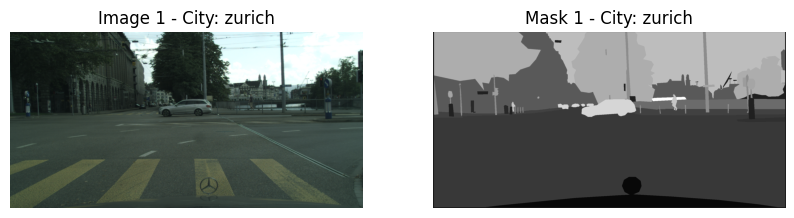

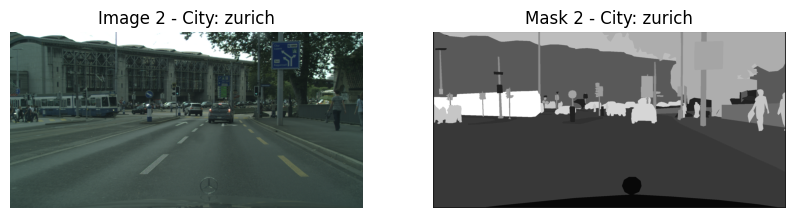

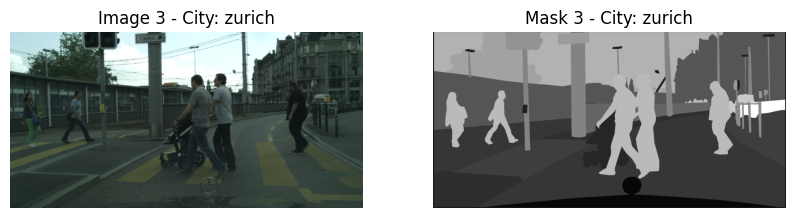

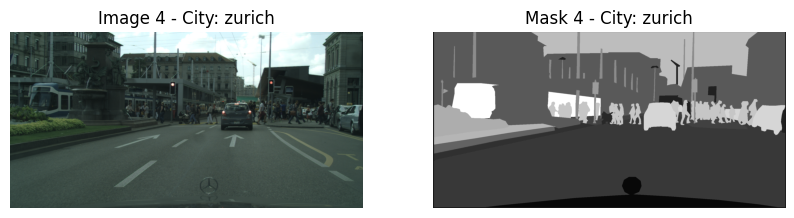

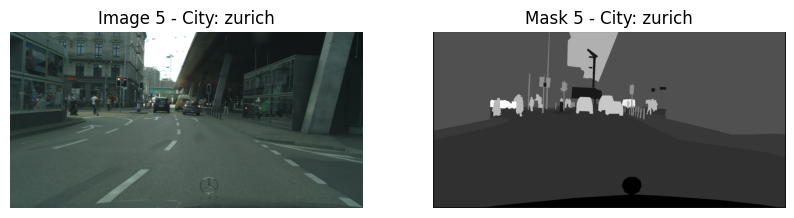

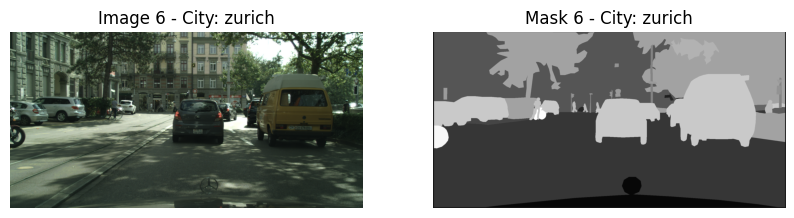

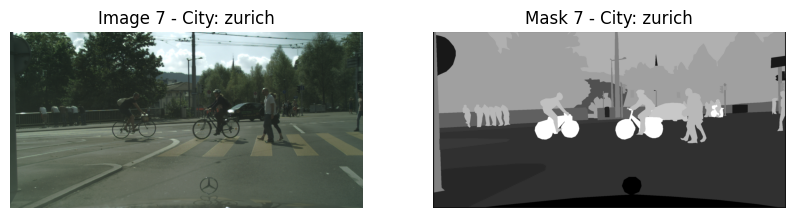

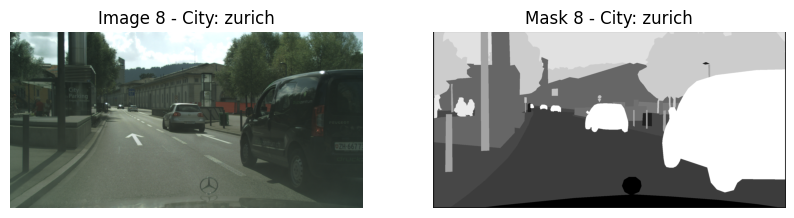

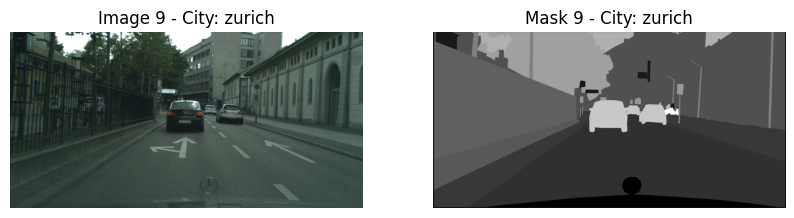

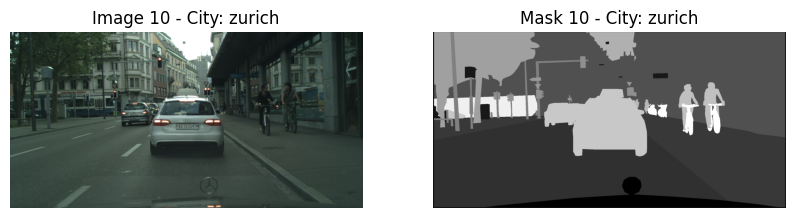

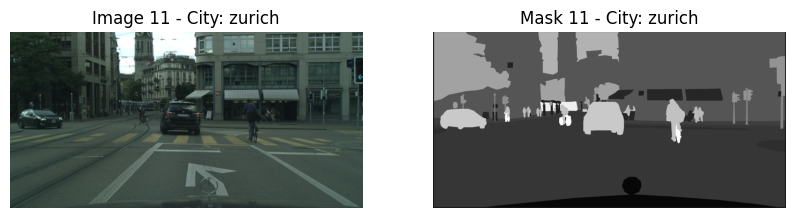

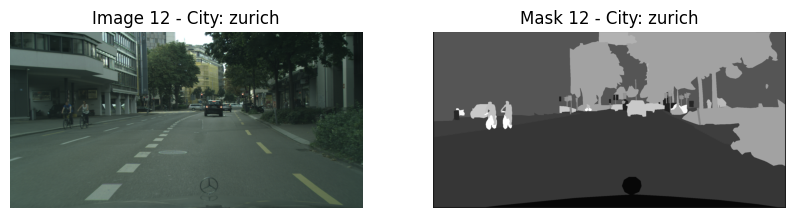

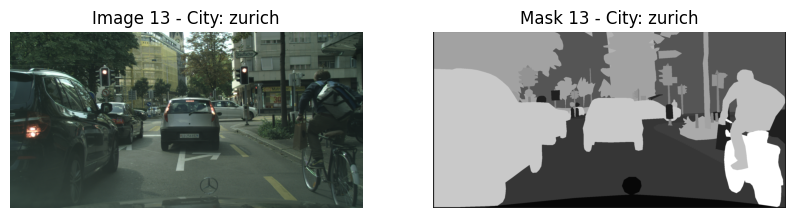

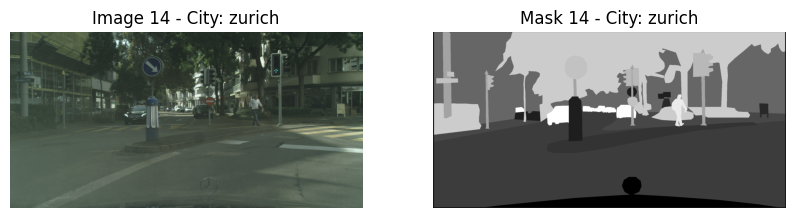

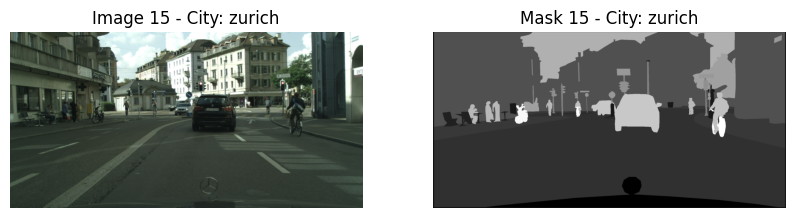

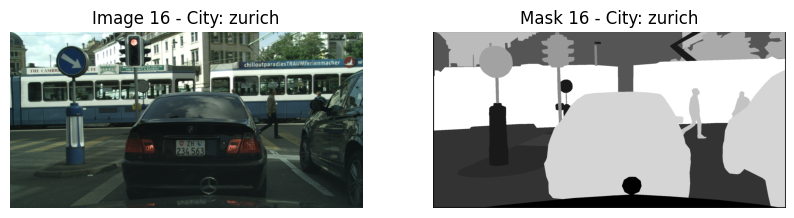

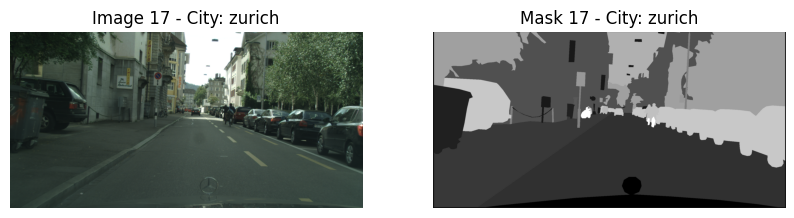

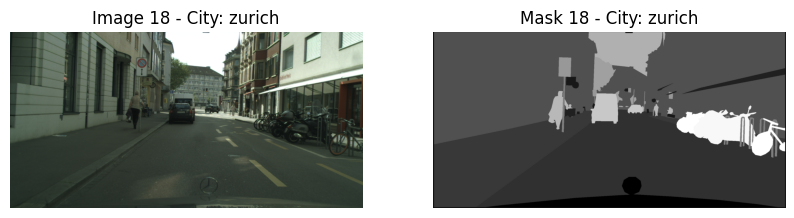

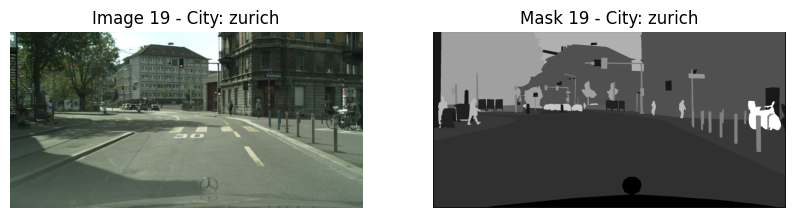

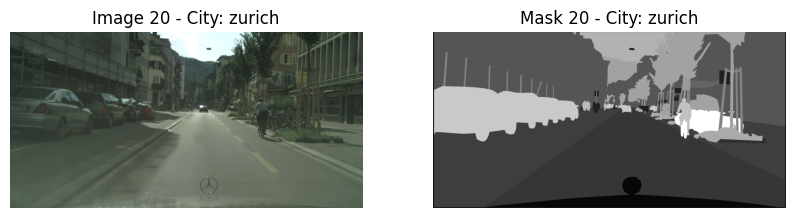

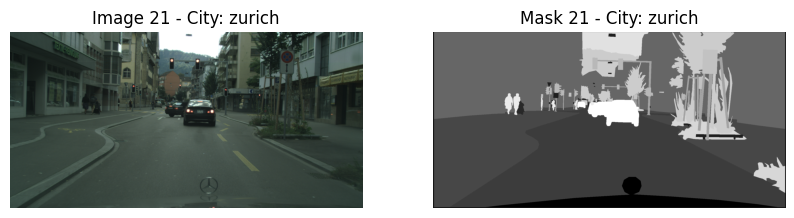

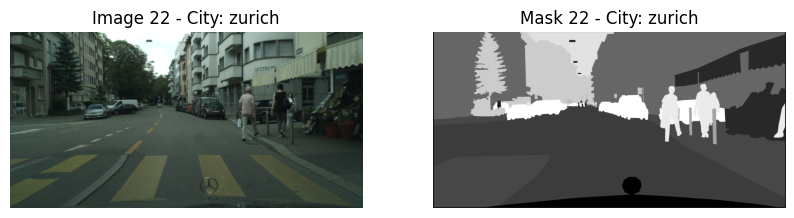

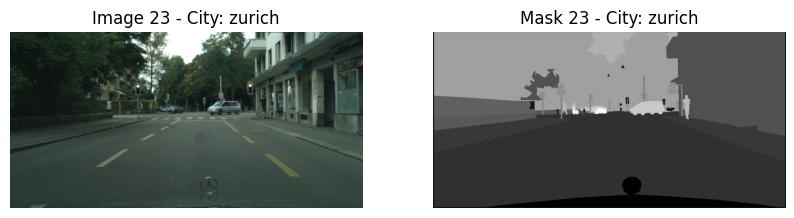

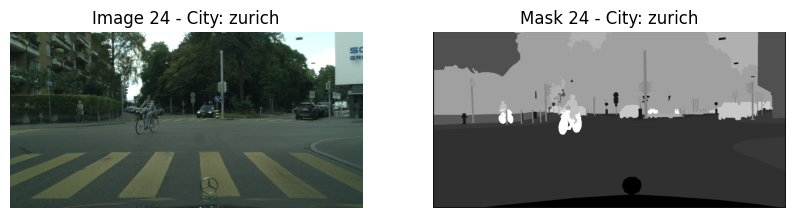

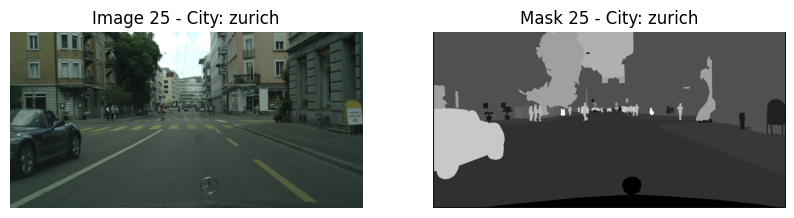

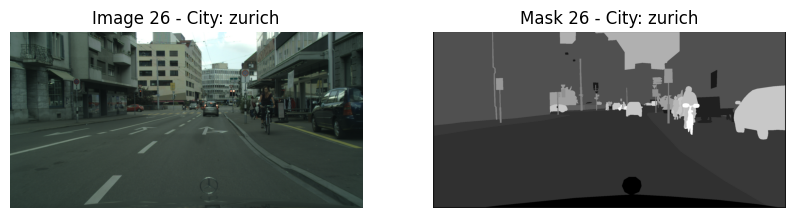

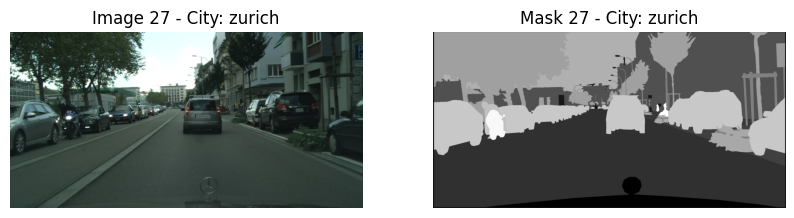

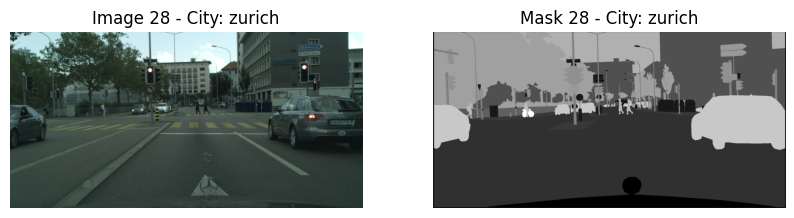

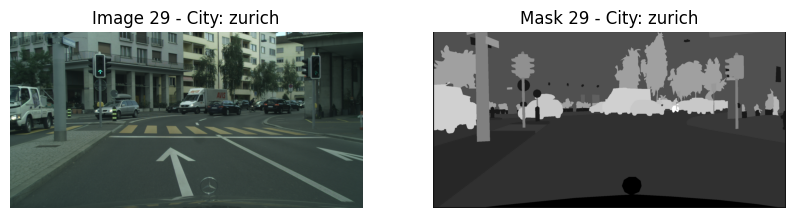

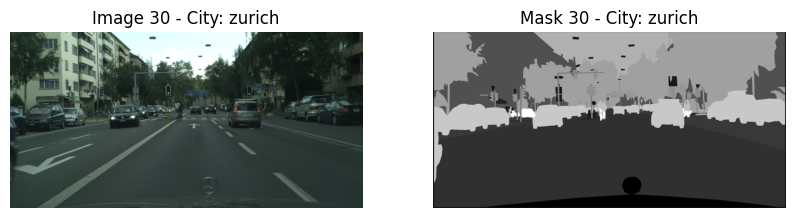

In [11]:
plot_images_and_masks(data_folder)

A PyTorch Dataset clas to load images and masks, apply transformations and make data handling efficient. This class ensures that the images and their corresponding masks are paired correctly when loading.

In [12]:
class Segmentation_Dataset(Dataset):


    def __init__(self, ImagesDirectory, MasksDirectory):
        self.ImagesDirectory = ImagesDirectory
        self.MasksDirectory = MasksDirectory
        self.image_paths = []
        self.mask_paths = []

        for city_folder in os.listdir(self.ImagesDirectory):
            city_image_path = os.path.join(self.ImagesDirectory, city_folder)
            city_mask_path = os.path.join(self.MasksDirectory, city_folder)

            if os.path.isdir(city_image_path) and os.path.isdir(city_mask_path):

                image_files = sorted(os.listdir(city_image_path))    # sorting image and masks file
                mask_files = sorted(os.listdir(city_mask_path))

                mask_files = [f for f in mask_files if 'labelIds' in f]

                for i in range(min(len(image_files), len(mask_files))):
                    image_path = os.path.join(city_image_path, image_files[i])
                    mask_path = os.path.join(city_mask_path, mask_files[i])
                    self.image_paths.append(image_path)
                    self.mask_paths.append(mask_path)


        self.image_transforms = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((192, 256), interpolation=transforms.InterpolationMode.NEAREST),
                    transforms.ToTensor()])

        self.mask_transforms = transforms.Compose([
            transforms.Resize((192, 256), interpolation=transforms.InterpolationMode.NEAREST)])


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        mask_path = self.mask_paths[index]


        img = io.read_image(img_path)
        mask = io.read_image(mask_path, mode=io.ImageReadMode.GRAY)


        img = self.image_transforms(img)
        mask = self.mask_transforms(mask)


        mask = mask.squeeze(0).long()       # long tensor

        return {"IMAGE": img, "MASK": mask}


Model Definition:
Encoder Block--> Define the encoder block, which extracts features from images by applying convolution and pooling. This part of the model learns to capture details like edges and textures.

In [13]:
class conv_block(nn.Module):
    def __init__(self, in_ch, n_filters=64, dropout_prob=0, max_pooling=True):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_ch, n_filters, kernel_size=(3, 3), padding=1)
        self.conv_2 = nn.Conv2d(n_filters, n_filters, kernel_size=(3, 3), padding=1)
        self.activation = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(n_filters)
        self.batch_norm2 = nn.BatchNorm2d(n_filters)
        self.max_pooling = max_pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) if self.max_pooling else None
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        out = self.conv_1(x)
        out = self.batch_norm1(out)
        out = self.activation(out)

        out = self.conv_2(out)
        out = self.batch_norm2(out)
        out = self.activation(out)

        if self.dropout_prob > 0:
            out = self.dropout(out)

        skip_connection = out

        if self.max_pooling:
            out = self.pool(out)

        next_layer = out
        return next_layer, skip_connection

Decoder Block: It upscales feature maps from the encoder to reconstruct the segmented via the help of skip connection to retain details

In [14]:
class upsampling_block(nn.Module):
    def __init__(self, in_ch, skip_ch, n_filters=32, use_batch_norm=True, activation_fn=nn.ReLU):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=(2, 2), stride=2)
        self.conv_1 = nn.Conv2d(in_ch // 2 + skip_ch, n_filters, kernel_size=(3, 3), padding=1)
        self.conv_2 = nn.Conv2d(n_filters, n_filters, kernel_size=(3, 3), padding=1)
        self.activation = activation_fn()

        self.use_batch_norm = use_batch_norm
        if self.use_batch_norm:
            self.batch_norm1 = nn.BatchNorm2d(n_filters)
            self.batch_norm2 = nn.BatchNorm2d(n_filters)

    def forward(self, expansive_input, contractive_input):
        conv = self.upsample(expansive_input)


        if conv.shape[2:] != contractive_input.shape[2:]:
            conv = nn.functional.interpolate(conv, size=contractive_input.shape[2:], mode='bilinear', align_corners=True)

        conv = torch.cat([conv, contractive_input], dim=1)
        conv = self.conv_1(conv)

        if self.use_batch_norm:
            conv = self.batch_norm1(conv)
        conv = self.activation(conv)

        conv = self.conv_2(conv)
        if self.use_batch_norm:
            conv = self.batch_norm2(conv)
        conv = self.activation(conv)

        return conv

U-net model assembly

In [15]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, n_filters=64, n_classes=34):

        super().__init__()
        self.conv_layer_1 = conv_block(in_ch, n_filters)
        self.conv_layer_2 = conv_block(n_filters, n_filters*2)
        self.conv_layer_3 = conv_block(n_filters*2,  n_filters*4)
        self.conv_layer_4 = conv_block(n_filters*4, n_filters*8, dropout_prob=0.3)
        self.conv_layer_5 = conv_block(n_filters*8, n_filters*16, dropout_prob=0.3, max_pooling=False)

        self.upsample_layer_1 = upsampling_block(n_filters*16, n_filters*8, n_filters * 8)
        self.upsample_layer_2 = upsampling_block(n_filters*8, n_filters*4, n_filters * 4)
        self.upsample_layer_3 = upsampling_block(n_filters*4, n_filters*2, n_filters * 2)
        self.upsample_layer_4 = upsampling_block(n_filters*2, n_filters*1, n_filters * 1)

        self.last_conv = nn.Sequential(
            nn.Conv2d(n_filters, n_filters,  kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(n_filters, n_classes,  kernel_size=(1, 1), padding=0),)


    def forward(self, x):

        conv_1_next, conv_1_skip = self.conv_layer_1(x)
        conv_2_next, conv_2_skip = self.conv_layer_2(conv_1_next)
        conv_3_next, conv_3_skip = self.conv_layer_3(conv_2_next)
        conv_4_next, conv_4_skip = self.conv_layer_4(conv_3_next)
        conv_5_next, conv_5_skip = self.conv_layer_5(conv_4_next)

        out = self.upsample_layer_1(conv_5_next, conv_4_skip)
        out = self.upsample_layer_2(out, conv_3_skip)
        out = self.upsample_layer_3(out, conv_2_skip)
        out = self.upsample_layer_4(out, conv_1_skip)

        out = self.last_conv(out)
        return out

In [16]:
num_classes = 34
unet = UNet(in_ch=3, n_filters=64, n_classes=num_classes).to(device)

In [17]:
image_path = "/content/drive/MyDrive/train"
mask_path = "/content/drive/MyDrive/gtFine_trainvaltest (2)/gtFine/train"

dataset = Segmentation_Dataset(ImagesDirectory=image_path, MasksDirectory=mask_path)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)



In [18]:
for i, batch in enumerate(dataloader):
    print("Image batch shape:", batch["IMAGE"].shape)  # shape-->[32, 3, 192, 256]
    print("Mask batch shape:", batch["MASK"].shape)    # shape--> [32, 192, 256]
    if i == 0:
        break

Image batch shape: torch.Size([32, 3, 192, 256])
Mask batch shape: torch.Size([32, 192, 256])


In [19]:
def display(display_list):
    plt.figure(figsize=(5, 5))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    if len(title) != len(display_list):
        title = [f'Image {i+1}' for i in range(len(display_list))]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])

        img = display_list[i].cpu().detach() if isinstance(display_list[i], torch.Tensor) else display_list[i]


        if isinstance(img, torch.Tensor):

            if img.dim() == 3:
                img = img.permute(1, 2, 0)
                if img.max() > 1:
                    img = img / 255.0

            elif img.dim() == 2:

                plt.imshow(img, cmap='tab20')

        else:
            plt.imshow(img)

        plt.axis('off')
    plt.show()

In [20]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    titles = ['Input Image', 'True Mask', 'Predicted Mask']

    for i, item in enumerate(display_list):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(titles[i])

        if isinstance(item, torch.Tensor):
            item = item.cpu().detach()  # Move to CPU, detached from the computational graph


        if item.ndim == 3:      # [C, H, W] -->[H, W, C] for images
            item = item.permute(1, 2, 0)
            plt.imshow(item)
        elif item.ndim == 2:
            plt.imshow(item, cmap='tab20')

        plt.axis('off')
    plt.show()

In [21]:

EPOCHS = 30
BATCH_SIZE = 32
LR = 0.001
B1 = 0.9
B2 = 0.999

In [22]:
criterion = nn.CrossEntropyLoss() # Loss Function

In [23]:
optimizer = torch.optim.Adam(unet.parameters(), lr=LR, betas=(B1, B2)) # Adam Optimizer

Training loop and loss tracking

In [24]:
losses = []
for epoch in range(EPOCHS):
    epoch_losses = []
    unet.train()

    for i, batch in enumerate(dataloader):
        images = batch['IMAGE'].to(device)
        masks = batch['MASK'].to(device)


        if masks.dim() == 4 and masks.shape[1] == 1: ##correct shape--> [N, H, W]
            masks = masks.squeeze(1)

        masks = masks.long()  # Convert masks -->long--> CrossEntropyLoss

        optimizer.zero_grad()
        outputs = unet(images)

        loss = criterion(outputs, masks)
        epoch_losses.append(loss.item() * images.size(0))

        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch+1}/{EPOCHS}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

    avg_epoch_loss = np.sum(epoch_losses) / len(dataloader.dataset)
    losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}] completed with average loss: {avg_epoch_loss:.4f}')

Epoch [1/30], Batch [1/3], Loss: 3.4915
Epoch [1/30], Batch [2/3], Loss: 3.2971
Epoch [1/30], Batch [3/3], Loss: 3.0406
Epoch [1/30] completed with average loss: 3.2950
Epoch [2/30], Batch [1/3], Loss: 2.8488
Epoch [2/30], Batch [2/3], Loss: 2.5677
Epoch [2/30], Batch [3/3], Loss: 2.2890
Epoch [2/30] completed with average loss: 2.5905
Epoch [3/30], Batch [1/3], Loss: 2.1580
Epoch [3/30], Batch [2/3], Loss: 1.9086
Epoch [3/30], Batch [3/3], Loss: 1.7689
Epoch [3/30] completed with average loss: 1.9590
Epoch [4/30], Batch [1/3], Loss: 1.7397
Epoch [4/30], Batch [2/3], Loss: 1.5560
Epoch [4/30], Batch [3/3], Loss: 1.6406
Epoch [4/30] completed with average loss: 1.6458
Epoch [5/30], Batch [1/3], Loss: 1.5125
Epoch [5/30], Batch [2/3], Loss: 1.4441
Epoch [5/30], Batch [3/3], Loss: 1.5201
Epoch [5/30] completed with average loss: 1.4900
Epoch [6/30], Batch [1/3], Loss: 1.4081
Epoch [6/30], Batch [2/3], Loss: 1.4701
Epoch [6/30], Batch [3/3], Loss: 1.1844
Epoch [6/30] completed with average

Mask Creation

In [25]:
def create_mask(pred_mask):
    pred_mask = torch.argmax(pred_mask, dim=1).detach()
    pred_mask = pred_mask.cpu()
    pred_mask = pred_mask.to(torch.uint8)
    return pred_mask

In [26]:
def show_predictions(dataloader, device, num=1):

    unet.eval()
    for i, batch in enumerate(dataloader):

        if batch["IMAGE"].size(0) < 1:  # batch has at least one sample
            continue

        IMG = batch["IMAGE"][0].to(device).unsqueeze(0)  # Shape-->[1, C, H, W]
        MASK = batch["MASK"][0].to(device)  # Shape--> [H, W]

        with torch.no_grad():
            pred_mask = unet(IMG)

        input_img = IMG[0].cpu() / 255.0 if IMG.max() > 1 else IMG[0].cpu()
        true_mask = MASK.cpu()
        predicted_mask = create_mask(pred_mask).cpu()

        display([input_img, true_mask, predicted_mask])

        if i >= num - 1:
            break


Though the predicted mask seem little undistinguishable for all the 34 classes highlighted in the dataset but the segmentation of vehicles around and freeway is very well noticeable via color blocks.

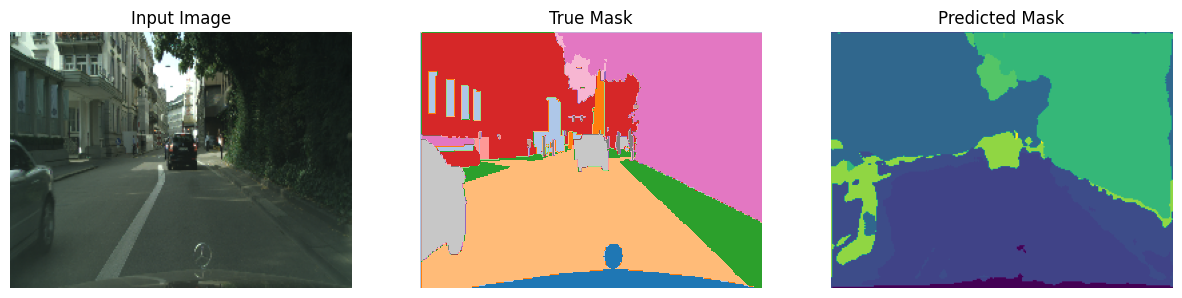

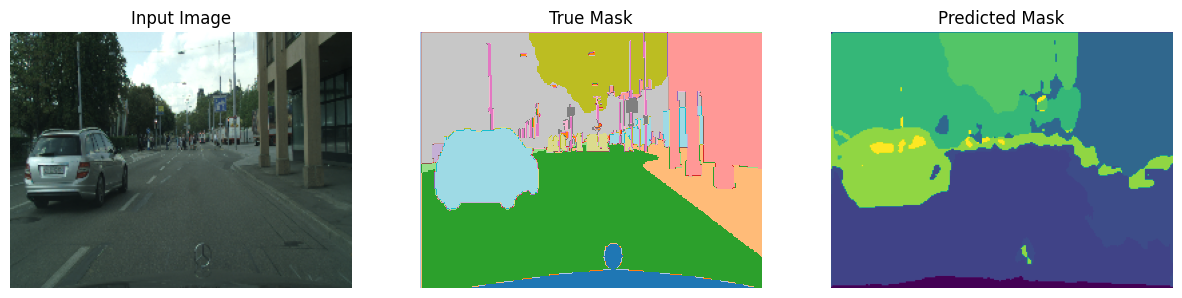

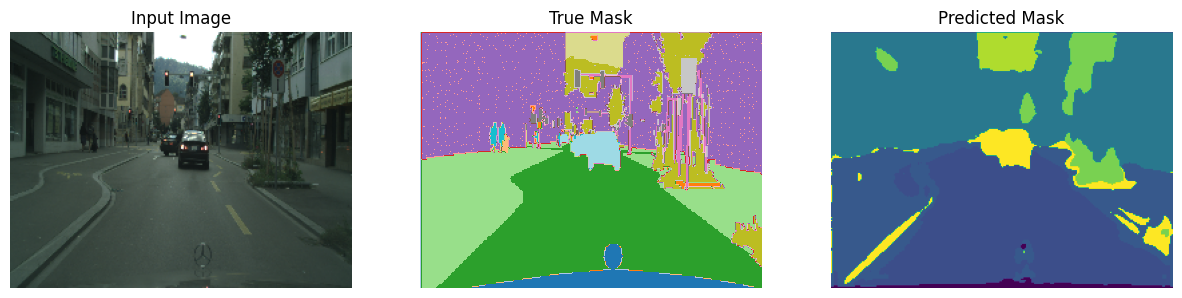

In [68]:
show_predictions(dataloader=dataloader, device=device,num=31)

Training loss decresases steadily over epochs, suggesting that the model is learning from the data effectively.

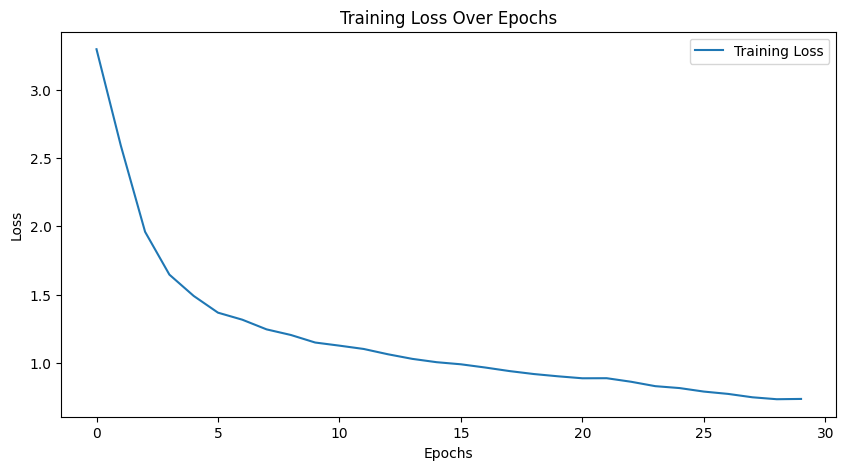

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(EPOCHS), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()